In [1]:
#Import Packages
import os
import pandas as pd
import numpy as np

#Change Working Directory
os.chdir(r'C:\Users\malva\Thesis')

#Read data file
data = pd.read_csv('Files\Samples\ValdAran_Sample.csv')
data.head()

,lat,long,elevation,slope,aspect,curv_plan,curv_prof,facc,twi,soil,lulc,rain_ant,rain_event,pof_event,pof_dry,pof_sat,response
0,4738872.5,311597.5,790.80,13.145604,327.05750,0.025769,-0.010359,1.397940,4.673251,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
1,4738862.5,311617.5,794.77,18.441340,307.93506,-0.117006,-0.044545,2.352183,6.514342,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
2,4738697.5,319872.5,1709.36,43.968290,173.81042,0.000644,0.018706,2.889302,6.688886,8.0,1.0,0.5,70.0,0.8803,0.3543,0.1197,1.0
3,4737832.5,318912.5,1285.22,47.644943,194.89754,0.076285,0.069331,0.000000,-11.605381,8.0,1.0,0.5,69.0,0.6894,0.5387,0.1381,1.0
4,4737377.5,317017.5,1734.32,39.489166,182.85223,-0.000287,-0.003942,3.122216,7.382731,8.0,1.0,0.5,67.0,0.6695,0.0711,0.3305,1.0


In [2]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
LULC: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0]


In [3]:
#Encoding Categorical with Pandas
X = pd.get_dummies(data, columns = ['soil', 'lulc'])
X = X.drop(columns=['lat', 'long', 'elevation', 'pof_event', 'pof_dry', 'pof_sat', 'response'])

In [4]:
#Complete missing columns
X['lulc_7.0'] = 0
X['lulc_10.0'] = 0
X.sort_index(axis=1, inplace=True)
X.columns

Index(['aspect', 'curv_plan', 'curv_prof', 'facc', 'lulc_1.0', 'lulc_10.0',
       'lulc_2.0', 'lulc_3.0', 'lulc_4.0', 'lulc_5.0', 'lulc_6.0', 'lulc_7.0',
       'lulc_8.0', 'lulc_9.0', 'rain_ant', 'rain_event', 'slope', 'soil_1.0',
       'soil_10.0', 'soil_11.0', 'soil_2.0', 'soil_3.0', 'soil_4.0',
       'soil_5.0', 'soil_6.0', 'soil_7.0', 'soil_8.0', 'soil_9.0', 'twi'],
      dtype='object')

In [5]:
#Create inputs and outputs for the data-driven model
y = data['response'].values

In [6]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
#Modules for Decision Tree
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [8]:
#Classification tree - No Rain

#Preliminary Tree
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt = clf_dt.fit(X_train.drop(columns=['rain_ant', 'rain_event']), y_train)

#Cost-complexity pruning
path = clf_dt.cost_complexity_pruning_path(X_train.drop(columns=['rain_ant', 'rain_event']), y_train)
ccp_alphas = path.ccp_alphas

#Array to Store Results
alpha_loop_values = []
clf_dts = []

#Alpha is sensitive to the sample, so use cross-validation
#5-fold Cross Validation
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train.drop(columns=['rain_ant', 'rain_event']), y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results_norain = pd.DataFrame(alpha_loop_values, columns=['Alpha', 'Accuracy', 'Std. Dev'])

print('Ideal CCP Alpha - No Rain')
print('ID ' + str(alpha_results_norain['Accuracy'].idxmax()))
print(alpha_results_norain.loc[alpha_results_norain['Accuracy'].idxmax()])

Ideal CCP Alpha - No Rain
ID 58
Alpha       0.010135
Accuracy    0.687701
Std. Dev    0.048295
Name: 58, dtype: float64


In [9]:
#Classification tree - Rain

#Preliminary Tree
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt = clf_dt.fit(X_train, y_train)

#Cost-complexity pruning
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

#Array to Store Results
alpha_loop_values = []
clf_dts = []

#Alpha is sensitive to the sample, so use cross-validation
#5-fold Cross Validation
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results_rain = pd.DataFrame(alpha_loop_values, columns=['Alpha', 'Accuracy', 'Std. Dev'])

print('Ideal CCP Alpha - Rain')
print(alpha_results_rain.loc[alpha_results_rain['Accuracy'].idxmax()])

Ideal CCP Alpha - Rain
Alpha       0.006155
Accuracy    0.737201
Std. Dev    0.033047
Name: 47, dtype: float64


In [10]:
#Select Alpha
#alpha_norain = 0.010135
alpha_norain = 0.014442
alpha_rain = 0.006155

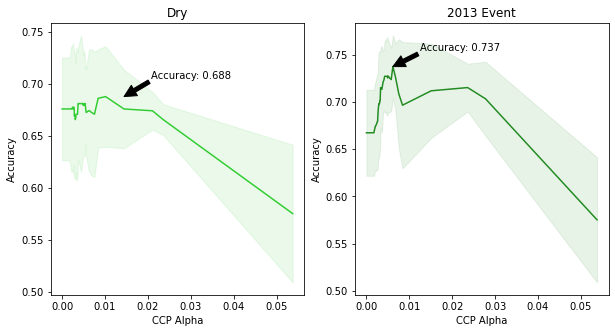

In [12]:
#Plot Tree Training
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(alpha_results_norain['Alpha'], alpha_results_norain['Accuracy'], color='limegreen')
ax[0].fill_between(alpha_results_norain['Alpha'], alpha_results_norain['Accuracy']-alpha_results_norain['Std. Dev'],
                   alpha_results_norain['Accuracy']+alpha_results_norain['Std. Dev'], color='limegreen', alpha=.1)
ax[0].annotate(text = "Accuracy: " + str(round(alpha_results_norain['Accuracy'].max(),3)),
               xy = (alpha_norain, alpha_results_norain['Accuracy'].max()),
               xytext=(alpha_norain+0.025, alpha_results_norain['Accuracy'].max()+0.025),
               arrowprops=dict(facecolor='black'),
               horizontalalignment='right', verticalalignment='top')
ax[0].set_title('Dry')
ax[0].set_xlabel('CCP Alpha')
ax[0].set_ylabel('Accuracy')

ax[1].plot(alpha_results_rain['Alpha'], alpha_results_rain['Accuracy'], color='forestgreen')
ax[1].fill_between(alpha_results_rain['Alpha'], alpha_results_rain['Accuracy']-alpha_results_rain['Std. Dev'],
                   alpha_results_rain['Accuracy']+alpha_results_rain['Std. Dev'], color='forestgreen', alpha=.1)
ax[1].annotate(text = "Accuracy: " + str(round(alpha_results_rain['Accuracy'].max(),3)),
               xy = (alpha_rain, alpha_results_rain['Accuracy'].max()),
               xytext=(alpha_rain+0.025, alpha_results_rain['Accuracy'].max()+0.025),
               arrowprops=dict(facecolor='black'),
               horizontalalignment='right', verticalalignment='top')
ax[1].set_title('2013 Event')
ax[1].set_xlabel('CCP Alpha')
ax[1].set_ylabel('Accuracy')

plt.savefig(r'C:\Users\malva\Desktop\Test\trainingtrees.png', dpi=300)
plt.show()

In [13]:
#Building the Classification Tree

#No Rain
clf_dt_norain = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha_norain)
dt_norain = clf_dt_norain.fit(X_train.drop(columns=['rain_ant', 'rain_event']), y_train)

#Rain
clf_dt_rain = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha_rain)
dt_rain = clf_dt_rain.fit(X_train, y_train)

In [14]:
#Save the Tree Models
import pickle

pkl_filename = "tree_norain_valdaran.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(dt_norain, file)
    
pkl_filename = "tree_rain_valdaran.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(dt_rain, file)

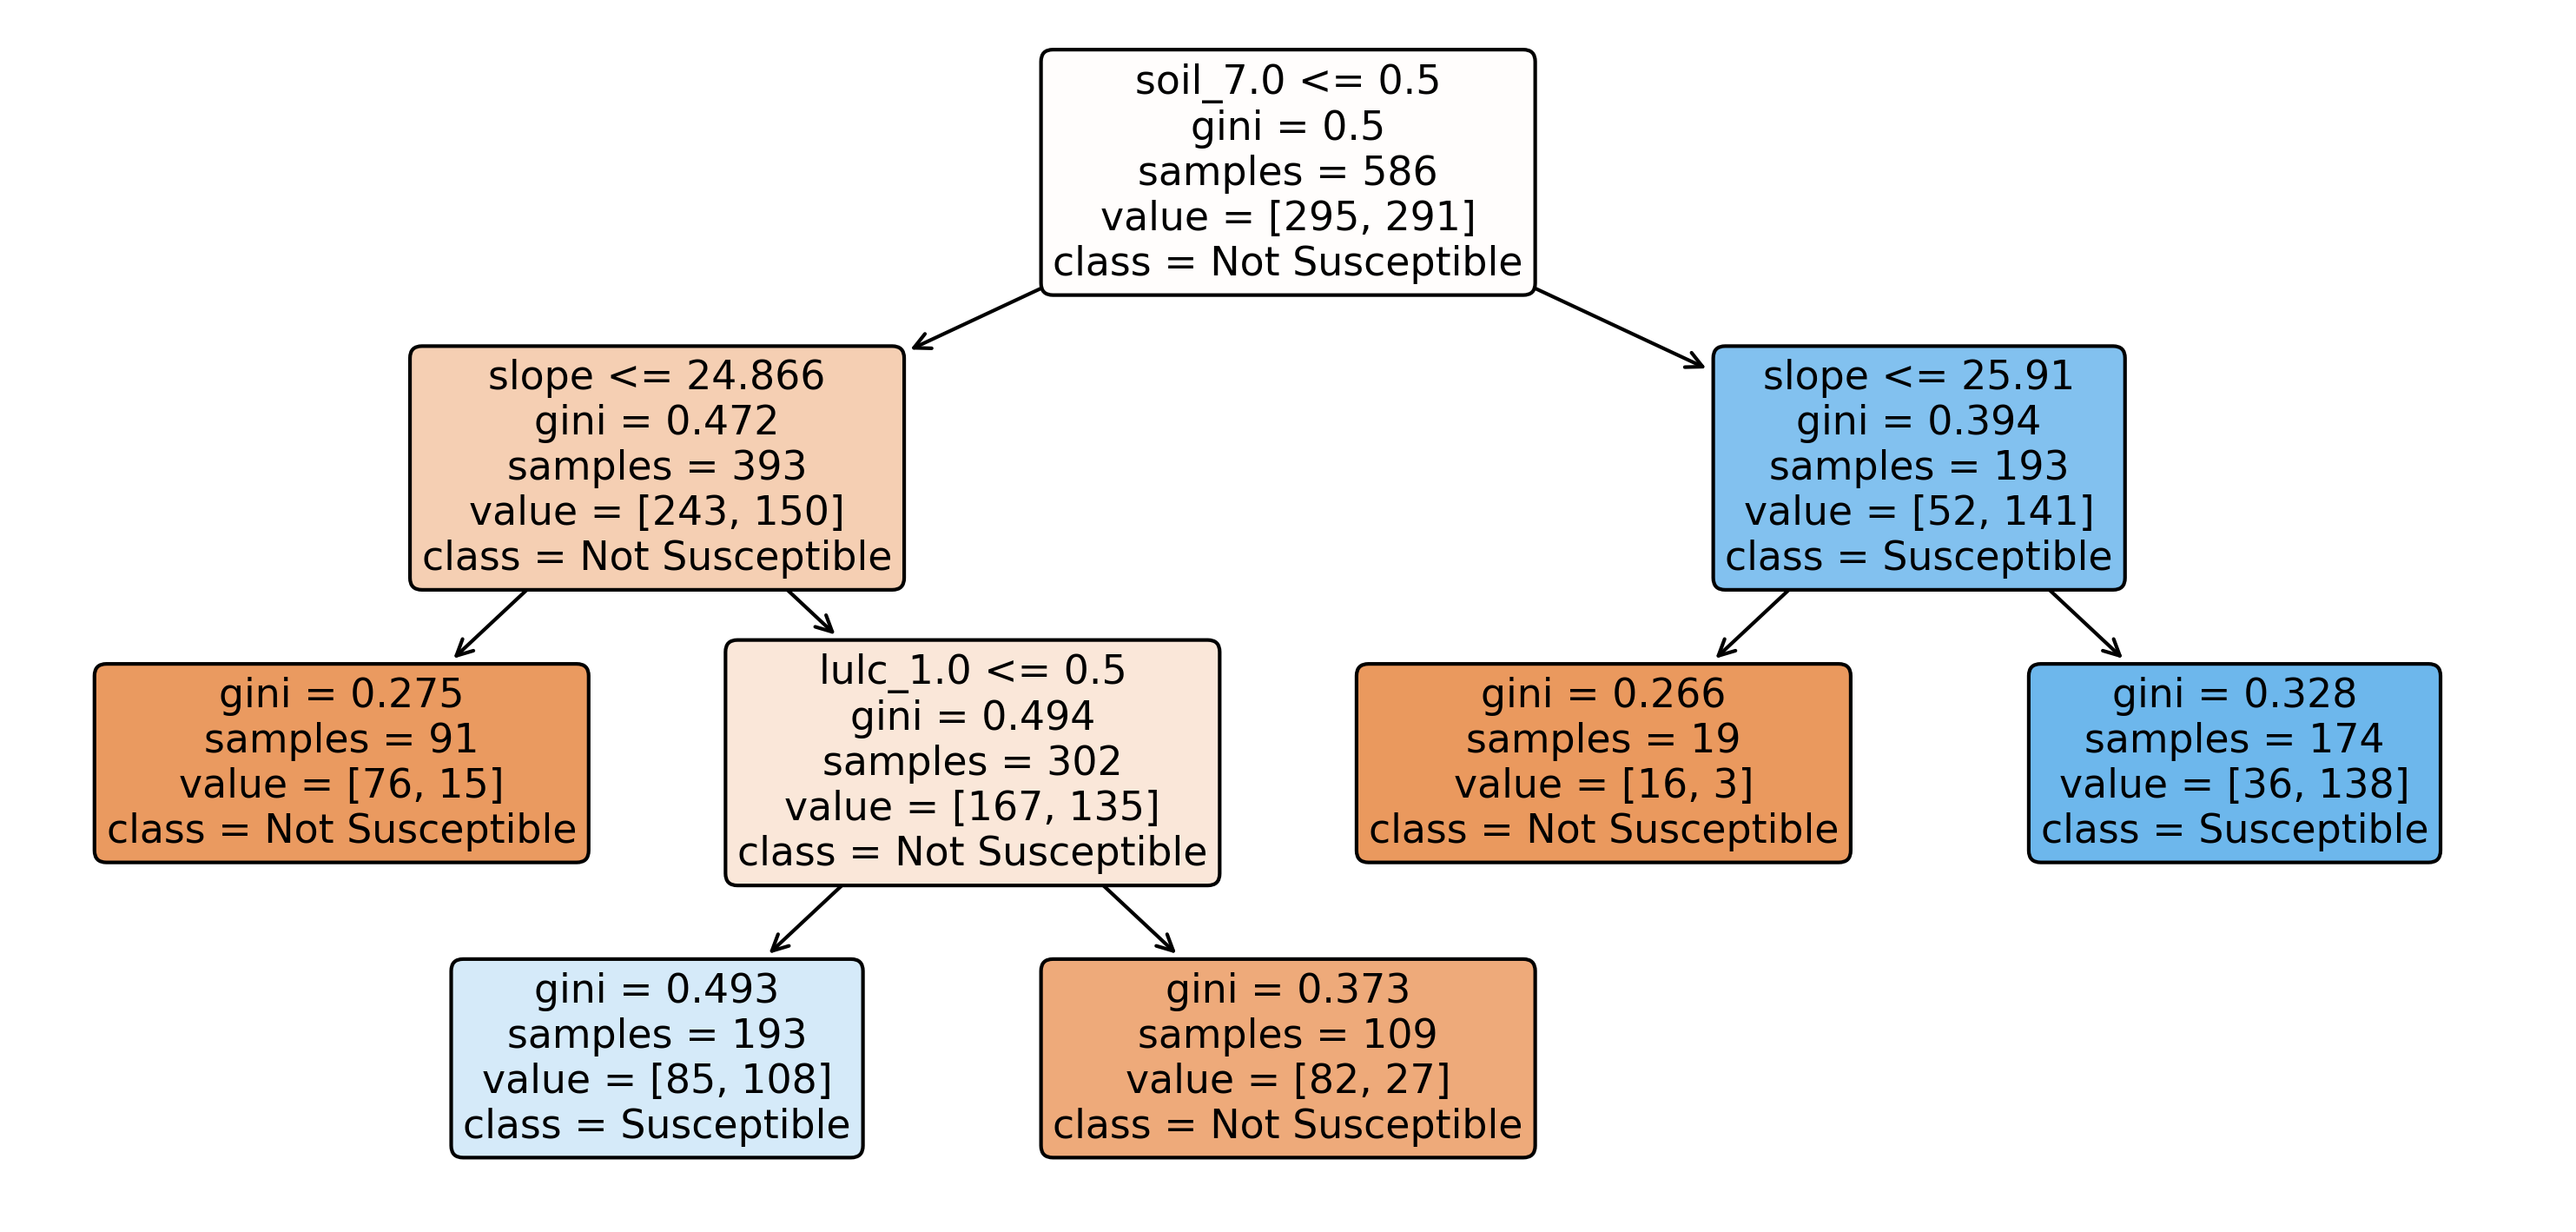

In [15]:
#Decision Tree - No Rain
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12.5, 6), dpi=300)
plot_tree(dt_norain,
          filled=True,
          rounded=True,
          class_names=["Not Susceptible", "Susceptible"],
          feature_names=X_train.drop(columns=['rain_ant', 'rain_event']).columns,fontsize=11);
plt.savefig(r'C:\Users\malva\Desktop\Test\norain_tree.png', dpi=300)

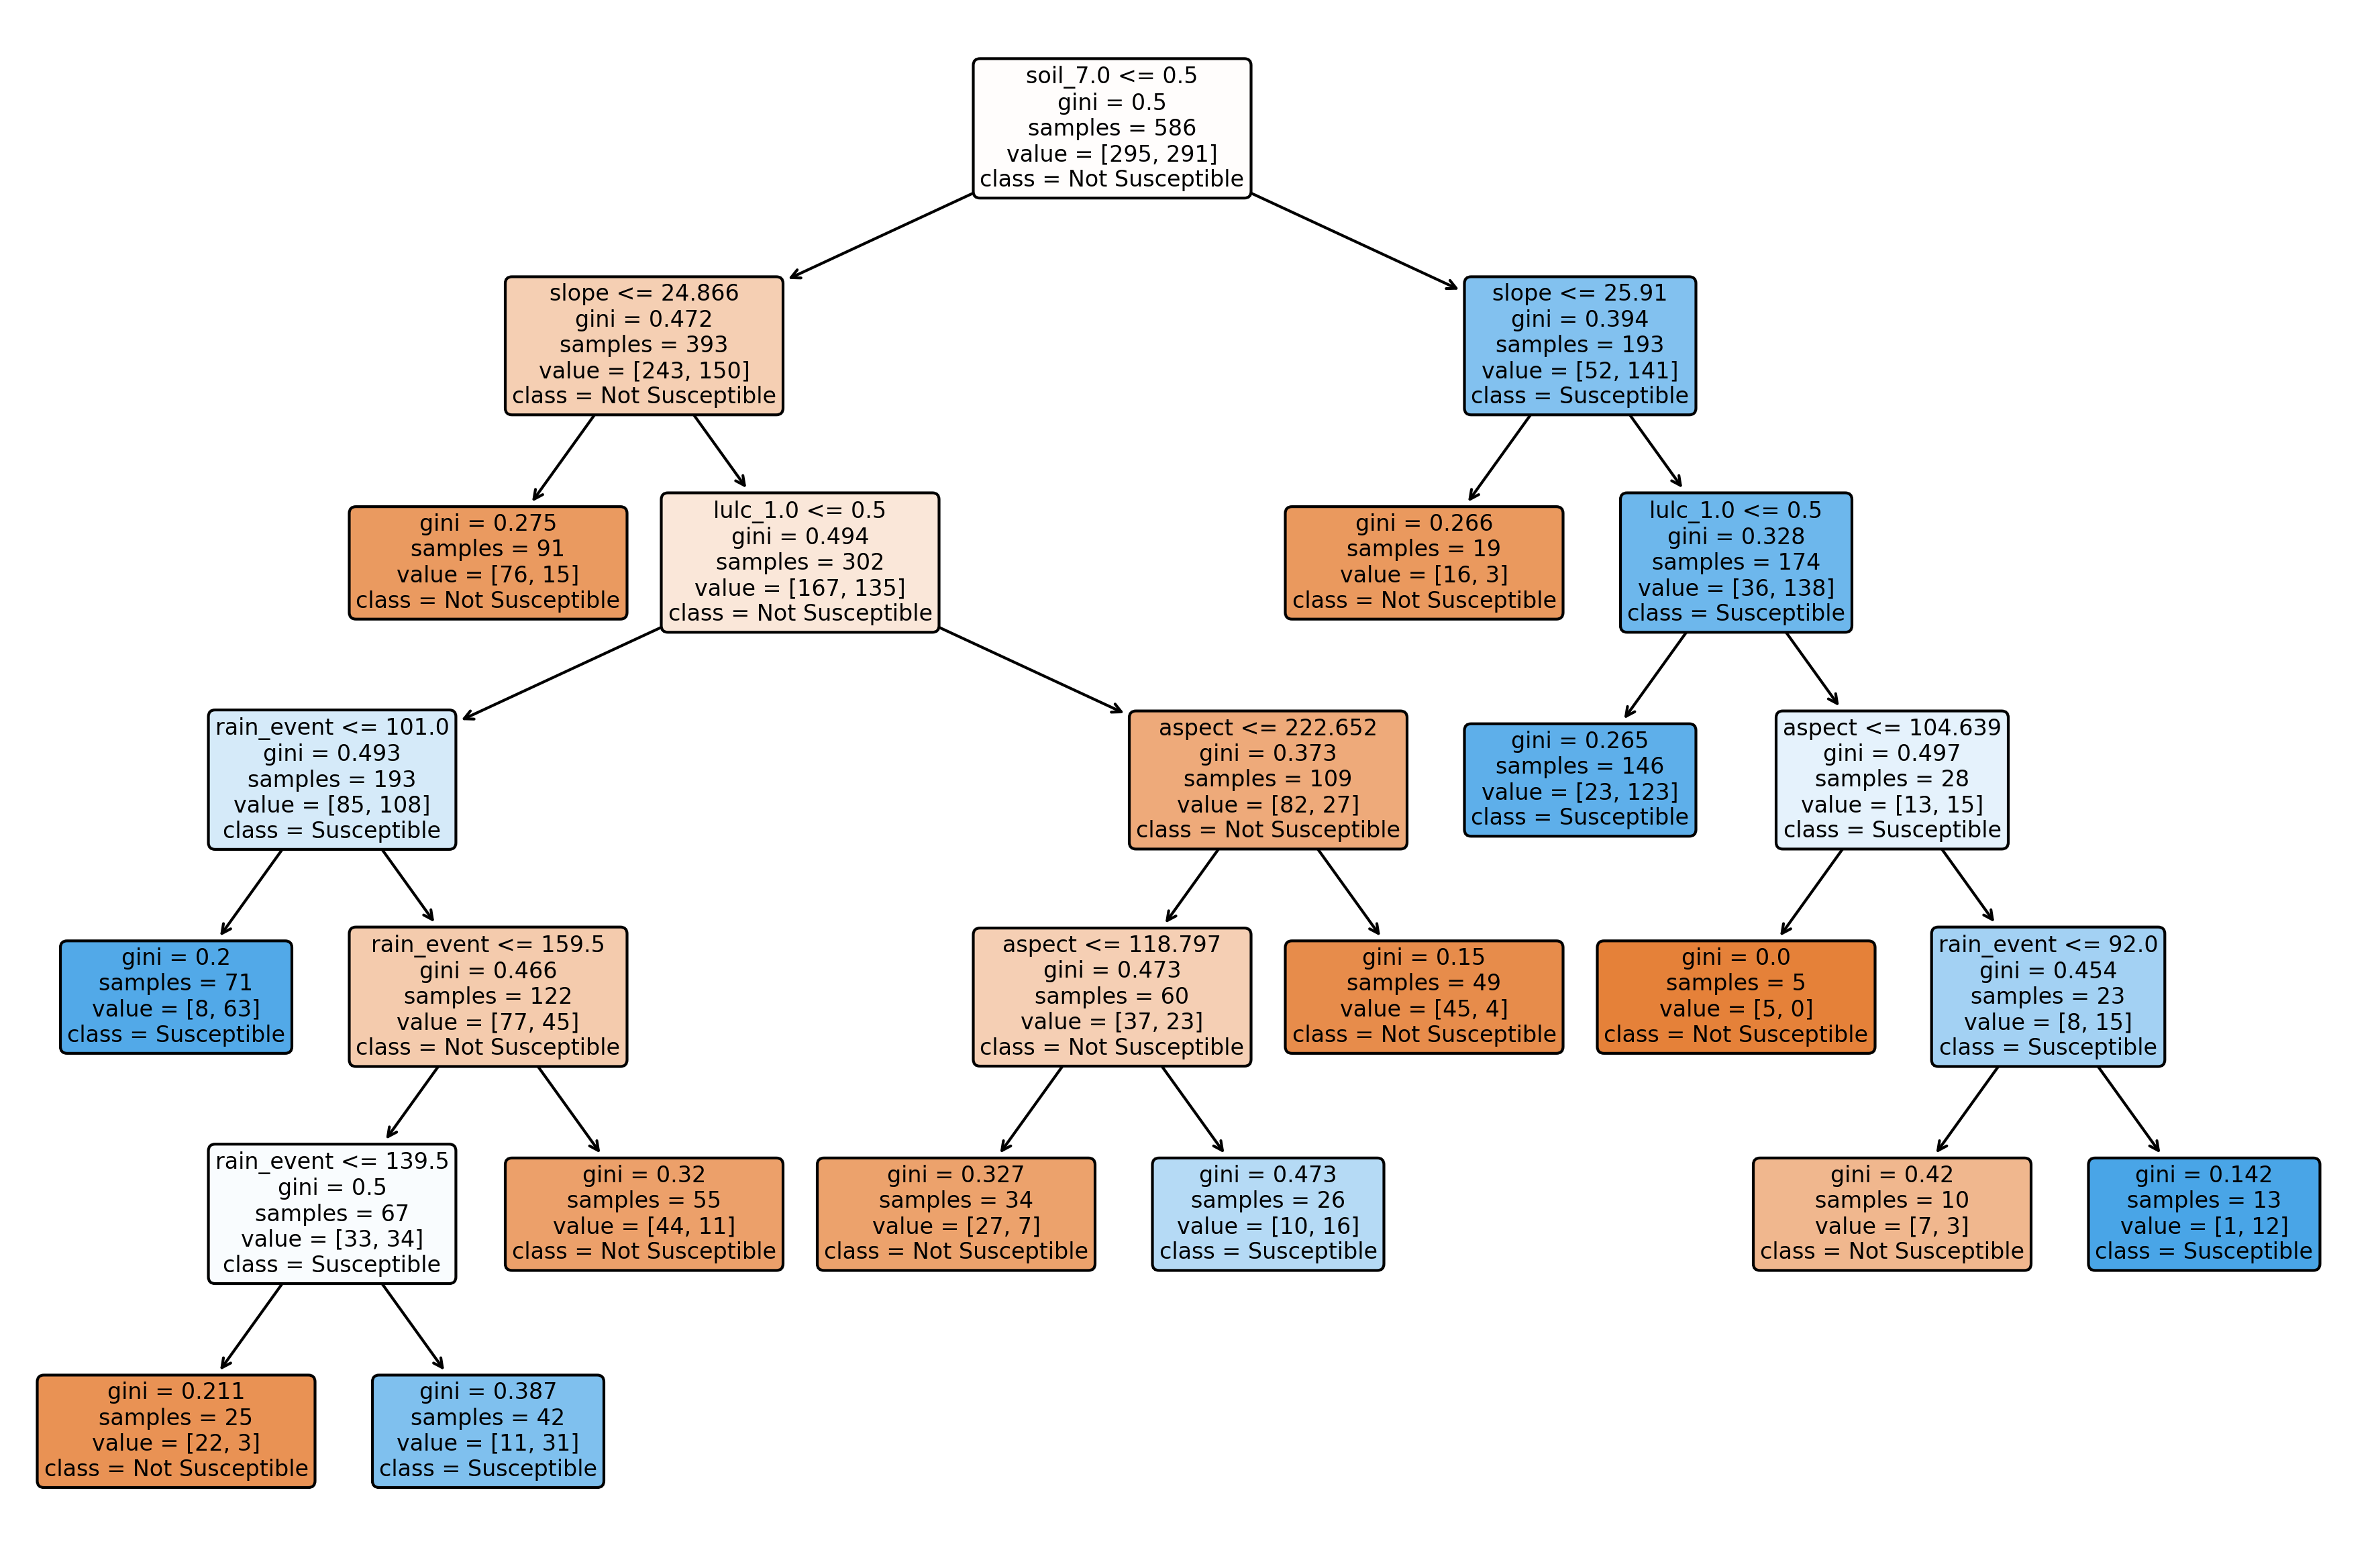

In [16]:
#Decision Tree - Rain
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10), dpi=300)
plot_tree(dt_rain,
          filled=True,
          rounded=True,
          class_names=["Not Susceptible", "Susceptible"],
          feature_names=X_train.columns,fontsize=8);
plt.savefig(r'C:\Users\malva\Desktop\Test\rain_tree.png', dpi=300)

In [17]:
#Make class predictions for the testing set
y_pred_norain = dt_norain.predict(X_test.drop(columns=['rain_ant', 'rain_event']))
y_pred_rain = dt_rain.predict(X_test)

#Confusion Matrix
matrix_norain = confusion_matrix(y_test, y_pred_norain)
matrix_rain = confusion_matrix(y_test, y_pred_rain)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

#No Rain
acc_norain = accuracy_score(y_test, y_pred_norain)
FP = matrix_norain[0,1]
TN = matrix_norain[0,0]
fpr_norain = FP/(FP+TN)
fnr_norain = 1 - recall_score(y_test, y_pred_norain)
mcc_norain = matthews_corrcoef(y_test, y_pred_norain)
stats_norain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_norain, fpr_norain, fnr_norain, mcc_norain)


#No Rain
acc_rain = accuracy_score(y_test, y_pred_rain)
FP = matrix_rain[0,1]
TN = matrix_rain[0,0]
fpr_rain = FP/(FP+TN)
fnr_rain = 1 - recall_score(y_test, y_pred_rain)
mcc_rain = matthews_corrcoef(y_test, y_pred_rain)
stats_rain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_rain, fpr_rain, fnr_rain, mcc_rain)

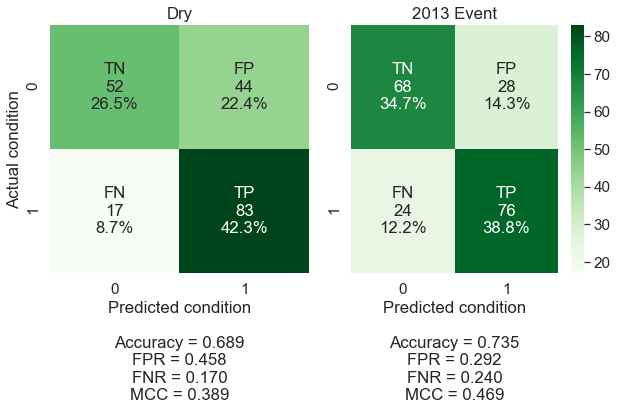

In [20]:
import seaborn as sns

sns.set(font_scale=1.4)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

low_lim = np.min(np.concatenate((matrix_norain, matrix_rain)))
upp_lim = np.max(np.concatenate((matrix_norain, matrix_rain)))

#Heatmap No Rain
group_names = ['TN', 'FP','FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in matrix_norain.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix_norain.flatten()/np.sum(matrix_norain)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_norain, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=False, cmap='Greens', ax=ax[0])

#Heatmap Rain
group_counts = ['{0:0.0f}'.format(value) for value in matrix_rain.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix_rain.flatten()/np.sum(matrix_rain)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_rain, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=True, cmap='Greens', ax=ax[1])

ax[0].set_title('Dry')
ax[1].set_title('2013 Event')
ax[0].set_ylabel('Actual condition')
ax[0].set_xlabel('Predicted condition' + stats_norain)
ax[1].set_xlabel('Predicted condition' + stats_rain)
plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\confusiontrees.png', dpi=300)
plt.show()